<h1><center>Boundary Data Immersion Method (BDIM)</center></h1>

---

<h3>Marin Lauber 2020</h3>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import NSsolver as ns
from scipy import optimize, linalg
try:
    plt.style.use("jupyter")
except OSError:
    print("Delaut syle in use")

<h2>1D Pipe Flow</h2>

In [3]:
def Body(x, X, t=10, e=2):
    # distance normalised by grid size
    d = abs((X - x)/(x[1]-x[0])) - t/2
    return mu_0(d, e), mu_1(d, e)

def mu_0(d, e):
    return np.where(d<=-e, 0, np.where(abs(d)<e, 0.5*(1 + d/e + 1./np.pi*np.sin(d*np.pi/e)), 1.))
    
def mu_1(d, e):
    return np.where(abs(d)<e, e*(0.25-(d/(2*e))**2 - 1./(2*np.pi)*((d/e)*np.sin(d*np.pi/e) +\
                                                                   (1./np.pi)*(1+np.cos(d*np.pi/e)))), 0)

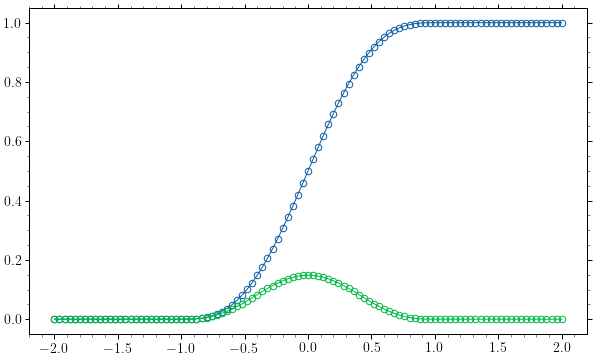

In [4]:
x, dx = np.linspace(-2, 2, 101, retstep=True)
plt.plot(x, mu_0(x, 1), "-o", x, mu_1(x, 1), "-o");
# mu0, mu1 = Body(x, 0, 10, 2)
# plt.plot(x, mu0, "-o", x, mu1, "-o");

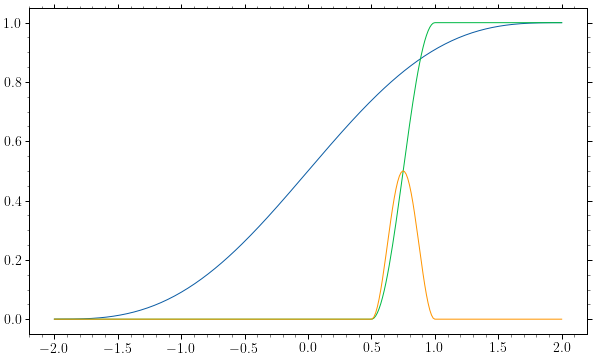

In [5]:
def mu_0_dev(d):
    return np.where(d<0.5, 0, np.where(d>1, 1, 0.5*(1+np.cos(2*d*np.pi))))
x, dx = np.linspace(-2, 2, 301, retstep=True)
plt.plot(x, mu_0(x, 2), "-", x, mu_0_dev(x), "-");
plt.plot(x, np.where(x<0.5, 0, np.where(x>1., 0, 0.25*(1-np.cos(x*np.pi*4)))));
# plt.plot(x, mu_1_dev(x), "-o");

In [6]:
def update(x, u, V, X, dx, dt, t):
    
    # get body position
    mu0, mu1 = Body(x, X, t, e=2)
    
    # predict velocity 
    u_star = mu0*(u + ns.r(u, dx)) + (1-mu0)*V + mu1*ns.ddn(u + ns.r(u, dx) - V, dx)
    
    # get pressure
    sigma = ns.div(u_star, dx)
    p = ns.solve_pressure(mu0, sigma, dx)
    
    # correct
    u_n = u_star - dt*mu0*ns.grad(p, dx)
    
    return mu0, mu1, u_star, sigma, p, u_n

In [7]:
N = 64
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.0 #np.random.rand()-0.5
V = 1
u0 = np.zeros_like(x)
dt = 1.

mu, mu1, us, sigma, p, u_n = update(x, u0, V, X, dx, dt, 10)
print("Interface at X: %.2f" % X)
print(r"L inf %.3e" % np.max(np.abs(u_n -  V)))

Interface at X: 0.00
L inf 5.672e-08


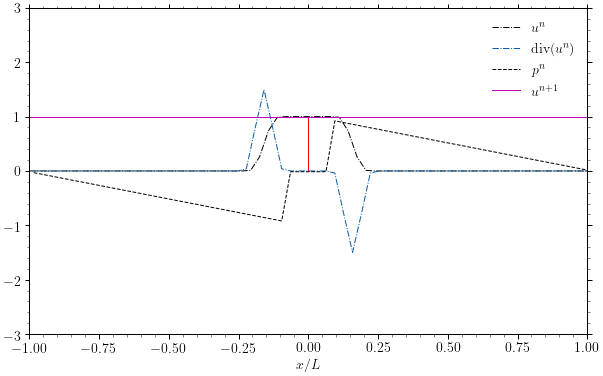

In [8]:
# plt.plot(x, mu1*ddn(u0 + r(u0, dx) - V, dx), ':k',lw=2,label=r"$\mu_1\partial_n(...)$")
plt.plot(x, us, '-.k', lw=1,label=r"$u^n$")
plt.plot(xs, sigma*.1, '-.', lw=1, label=r"div($u^n$)")
plt.plot(xs, p, '--k',  lw=1, label=r"$p^n$")
plt.plot(x, u_n, '-m', lw=1, label=r"$u^{n+1}$")
plt.vlines(X, 0, V, lw=1, color='red')
plt.legend()
plt.xlabel(r'$x/L$'); plt.xlim(-1,1); plt.ylim(-3,3);
# plt.savefig('Figure_1.png', dpi=900);

In [9]:
V = 1
u0 = np.zeros_like(x)
dt = 1.
x, dx = np.linspace(-1, 1, N, retstep=True)
Linf = np.empty((7, 11))

for t in np.arange(0, 7):
    for i, X in enumerate(np.linspace(0., dx/2, 11)):
        _,_,_,_,_,u_n = update(x, u0, V, x[N//2]+X, dx, dt, t)
        Linf[t, i] = np.max(np.abs(u_n -  V))

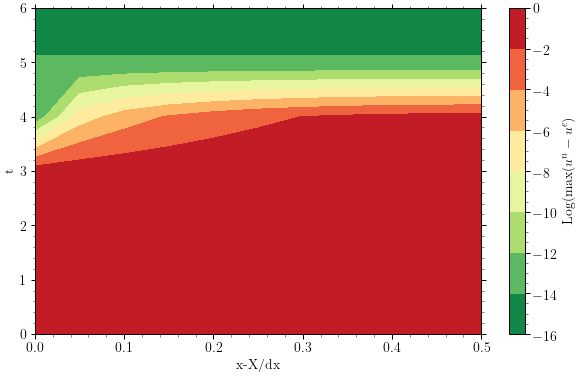

In [29]:
plt.contourf(np.linspace(0., dx/2, 11)/dx, np.arange(0, 7), np.log(Linf), cmap="RdYlGn_r")
plt.ylabel("t"); plt.xlabel("x-X/dx")
plt.colorbar(label=r"Log(max($u^n - u^e$)");

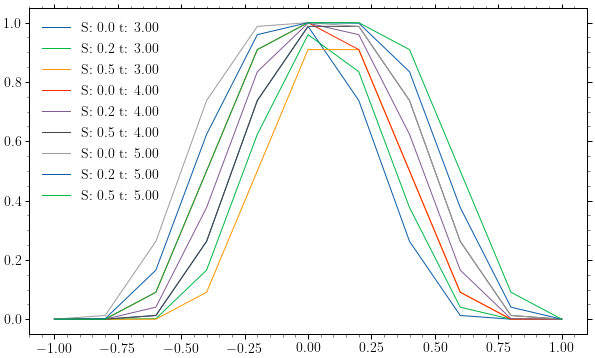

In [11]:
x, dx = np.linspace(-1, 1, 11, retstep=True)
for t in np.arange(3, 6, 1): 
    for S in np.linspace(0, dx/2, 3):
        mu0, _ = Body(x, S, t, 2)
        plt.plot(x, 1-mu0, "-", label=f"S: {(S/dx):.1f}      t: {t:.2f}")
plt.legend();

# Now change the Kernel

---

We can build a pressure field as we know what it should look like for an interface

In [12]:
def build_p(x, x_b, V):
    p = np.arange(0, len(x), 1)*V
    flipped = -np.flip(p[x>x_b])
    #ensures last term is correct
    corr = p[0] - flipped[-1] - V
    p[x>x_b] = flipped + corr
    p = p - np.mean(p)
    p[x==x_b] = (p[int(x_b-1)] + p[int(x_b+1)]) *.5
    return -p 

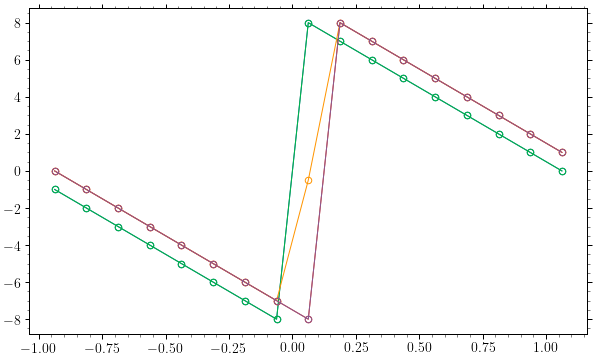

In [13]:
N = 16
V=1
X =0
x, dx = np.linspace(-1, 1, N+1, retstep=True)

for i, X in enumerate(np.linspace(0., dx/2, 5)):
    p = build_p(x+0.5*dx, X+0.25*dx, V)
    plt.plot(x+0.5*dx, p, "-o");

we basically have to find a $\mu_f$ such that

$$
    \partial_x(\mu_f\partial_x p) = \partial_x(u^*) = \partial((1-mu_f)*V)
$$

for any potision $X$ of the interface

In [14]:
def f(mu_f):
    return abs(ns.div(mu_f*ns.grad(p, dx), dx) - V*ns.div(1-mu_f, dx))

In [15]:
def NSerror(muf, u, V):
    # predict velocity
    mu0 = np.ones_like(u); mu0[len(u)//2] = muf
    u_star = mu0*(u + ns.r(u, dx)) + (1-mu0)*V
    sigma = ns.div(u_star, dx)
    p = ns.solve_pressure(mu0, sigma, dx)
    u_n = u_star - dt*mu0*ns.grad(p, dx)
    return np.max(np.abs(u_n - np.ones_like(u_n)))

In [16]:
N = 32
muf0 = .6
u0 = np.zeros(N)
res = optimize.fsolve(NSerror, muf0, args=(u0, 1.))
print(res)

[0.6]


In [17]:
NSerror(res, u0, 1.)

0.979591836734694

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


True
True
True
True
True


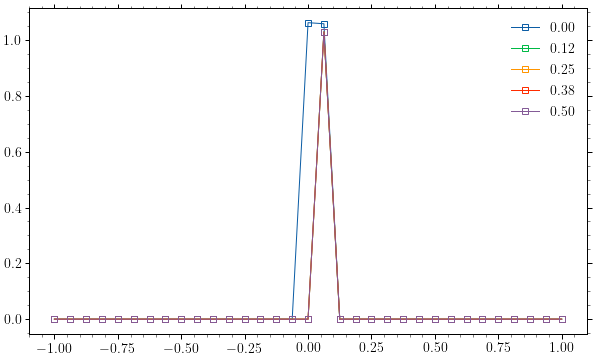

In [18]:
V=1
x, dx = np.linspace(-1, 1, N+1, retstep=True)
for i, X in enumerate(np.linspace(0., dx/2, 5)):
    p = build_p(x, X, V)
    muf = optimize.fsolve(f, np.ones_like(x))
    print(np.allclose(f(muf), 0.))
    plt.plot(x, 1-muf , "-s", label=f"{(X/dx):.2f}")
plt.legend();

In [19]:
def TopHat(x, X):
    dist = abs((X - x)/(x[1]-x[0]))
    mu_b = np.where(dist<=0.5, 1, 0)
    return 1.-mu_b

def Cosine(x, X):
    dist = abs((X - x)/(x[1]-x[0]))
#     mu_b = np.where(dist<=0.5,1,np.where(dist<=1.,.5*(1+np.cos(2*(dist-0.5)*np.pi)),0))
    mu_b = np.where(dist<=1,.5*(1+np.cos(dist*np.pi)),0)
    return 1.-mu_b

def Peskin(x, X):
    dist = abs((X - x)/(x[1]-x[0]))
    mu_b = np.where(dist<0.5,1./3.*(1+np.sqrt(-3*dist**2 + 1)),
                    np.where(dist<=1.5,1./6.*(5.-3*dist-np.sqrt(-3*(1.-dist)**2+1)),0.))
    return 1.-mu_b

def update(mu, u, V, dx, dt):
    
    # predict velocity 
    u_star = mu*(u + ns.r(u, dx)) + (1-mu)*V #+ mu1*ns.ddn(u + r(u, dx) - V, dx)
    
    # get pressure
    sigma = ns.div(u_star, dx)
    p = ns.solve_pressure(mu, sigma, dx)

    # correct
    u_n = u_star - dt*mu*ns.grad(p, dx)
    
    return u_star, sigma, p, u_n

Interface at X: 0.42
L inf: 6.883e-15
Interface at X: 0.42
L inf: 1.505e-01


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Interface at X: 0.42
L inf: 9.304e-01


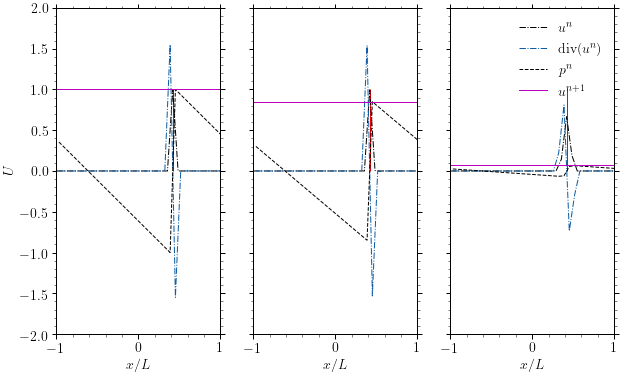

In [20]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = np.random.rand()-0.5
V = 1
u0 = np.zeros_like(x)
dt = 1.

fig, ax = plt.subplots(1,3,sharey=True)
for i,kern in enumerate([TopHat, Cosine, Peskin]):
    mu = kern(x, X)
    us, sigma, p, u_n = update(mu, u0, V, dx, dt)
    print("Interface at X: %.2f" % X)
    print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))
    ax[i].plot(x, us, '-.k', lw=1,label=r"$u^n$")
    ax[i].plot(xs, sigma*.1, '-.', lw=1, label=r"div($u^n$)")
    ax[i].plot(xs, p, '--k',  lw=1, label=r"$p^n$")
    ax[i].plot(x, u_n, '-m', lw=1, label=r"$u^{n+1}$")
    ax[i].vlines(X, 0, V, lw=1, color='red')
    ax[i].set_xlim(-1,1); ax[i].set_ylim(-2,2);
    ax[i].set_xlabel(r'$x/L$');
ax[2].legend()
ax[0].set_ylabel(r'$U$')
plt.savefig('kernel_comp.png', dpi=900);

In [21]:
def update(mu, u, V, dx, dt):
    
    # predict velocity 
    u_star = mu*(u + ns.r(u, dx)) + (1-mu)*V #+ mu1*ns.ddn(u + r(u, dx) - V, dx)
    
    # get pressure
    sigma = ns.div(u_star, dx)
    p = ns.solve_pressure(mu, sigma, dx)

    # correct
    u_n = u_star - dt*mu*ns.grad(p, dx)
    
    return u_star, sigma, p, u_n

Interface at X: -0.31
L inf: 6.883e-15


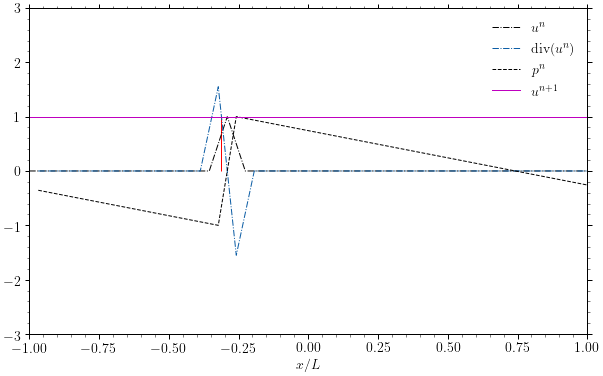

In [22]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = np.random.rand()-0.5
V = 1
u0 = np.zeros_like(x)
dt = 1.

mu = TopHat(x, X)
us, sigma, p, u_n = update(mu, u0, V, dx, dt)
print("Interface at X: %.2f" % X)
print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))
plt.plot(x, us, '-.k', lw=1,label=r"$u^n$")
plt.plot(xs, sigma*.1, '-.', lw=1, label=r"div($u^n$)")
plt.plot(xs, p, '--k',  lw=1, label=r"$p^n$")
plt.plot(x, u_n, '-m', lw=1, label=r"$u^{n+1}$")
plt.vlines(X, 0, V, lw=1, color='red')
plt.legend()
plt.xlabel(r'$x/L$'); plt.xlim(-1,1); plt.ylim(-3,3);

In [23]:
from scipy import sparse, optimize, linalg
def Kernel(x, X):
    d = abs((X - x)/(x[1]-x[0]))
    mu = np.zeros_like(d)
    mu[d==np.min(d)] = 1.
    return 1.-mu

def TopHat(x, X):
    d = abs((X - x)/(x[1]-x[0]))
    mu_b = np.where(d<0.5, 1, np.where(d<1., 0.5*(1+np.cos(2*(d-.5)*np.pi)), 0.))
    return 1.-mu_b

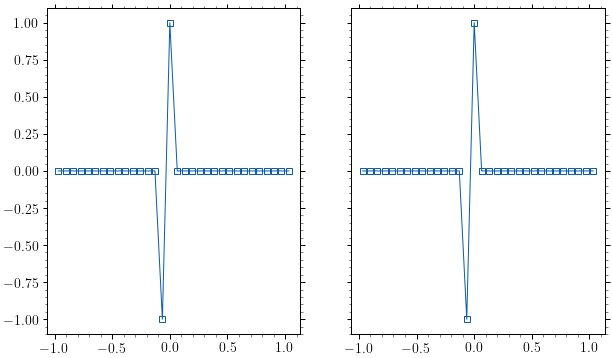

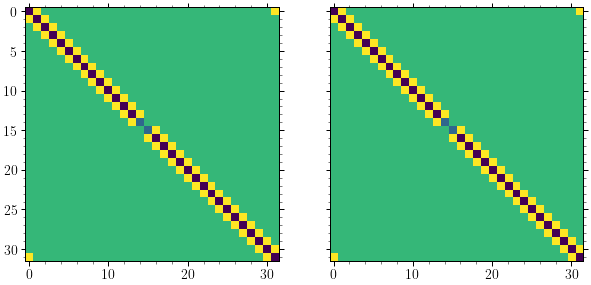

In [24]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.0*dx

fig, ax = plt.subplots(1, 2, sharey=True)
for j,k in enumerate([TopHat, Kernel]):
    beta = k(xs, X)
    ax[j].plot(xs, ns.div(beta), '-s')
plt.show()

fig, ax = plt.subplots(1, 2, sharey=True)
for j,k in enumerate([TopHat, Kernel]):
    beta = k(xs, X)
    L = ns.build_pressure_mat(beta, beta, dx)
    ax[j].imshow(L)

In [25]:
def kern_var(x, X, e=1.0, t=0.):
    d = abs((X - x)/(x[1]-x[0]))
    return np.where(d<=t, 1, np.where(d<e, 0.5*(1+np.cos(1/(e-t)*(d-t)*np.pi)), 0.))
# plt.plot(x, ns.div(kern(xs, X)));

2.0
L inf: 5.995e-15
2.0
L inf: 5.995e-15
2.0
L inf: 7.772e-15
2.0
L inf: 3.553e-15
2.0000000000000004
L inf: 4.330e-15
2.0
L inf: 1.632e-14
2.0
L inf: 7.772e-15


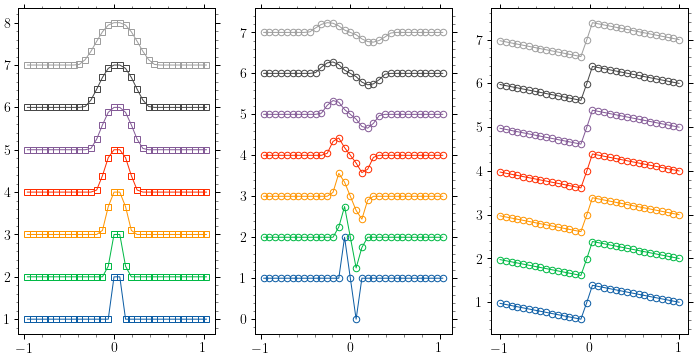

In [26]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.5*dx
V = 1
u0 = np.zeros_like(x)
dt = 1.

fig, ax = plt.subplots(1,3,figsize=(12,6))
for e in np.arange(1,8,1):
    mu = kern_var(xs, X, e, 0.5)
    div = ns.div(mu)
    ax[0].plot(xs, e+mu,  '-s')
    ax[1].plot(xs, e+div, '-o')
    print(sum(abs(div)))
    us, sigma, p, u_n = update(1.-mu, u0, V, dx, dt)
    ax[2].plot(x , e+p*0.4, '-o')
    print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))
    p = 0.; u_n = 0.
plt.show()

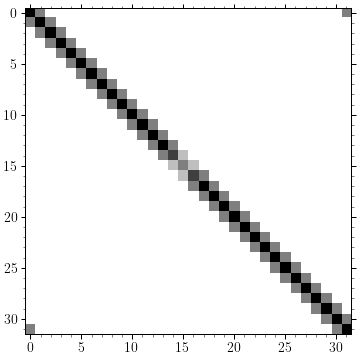

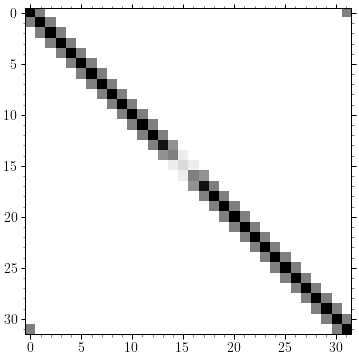

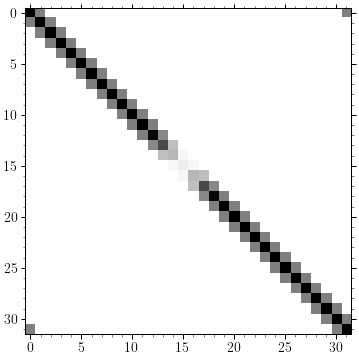

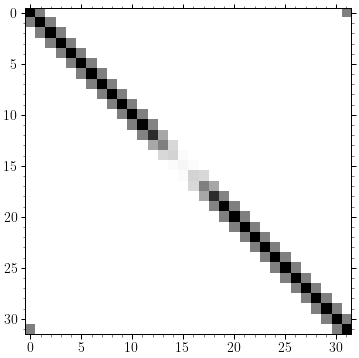

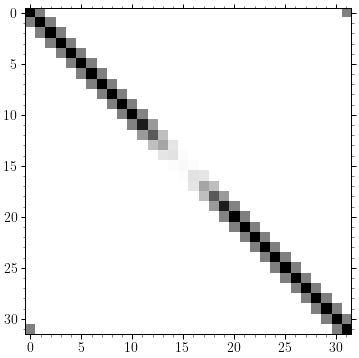

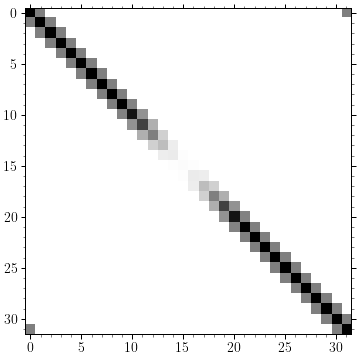

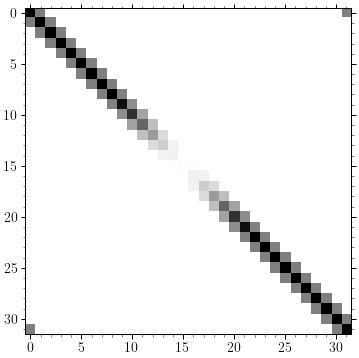

In [27]:
for e in np.arange(1,8,1):
    mu = kern_var(xs, X, e)
    L = ns.build_pressure_mat(1.-mu,mu,dx)
    plt.imshow(abs(L),cmap='binary'); plt.show()

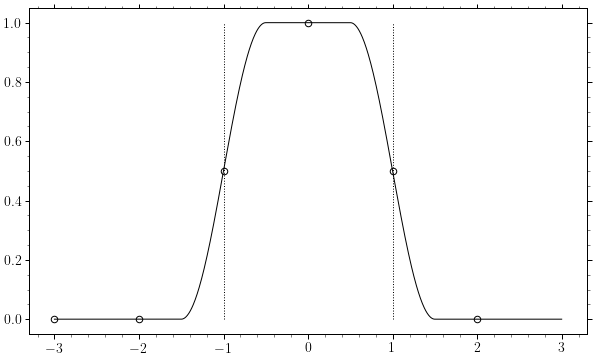

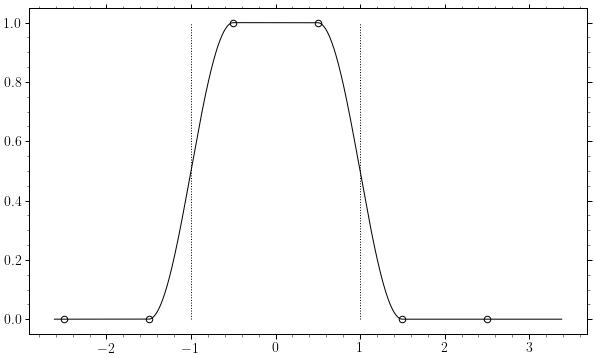

In [28]:
d = np.linspace(-3,3,2**10)
e = 1.5
t = 0.5
plt.plot(d,np.where(abs(d)<t, 1, np.where(abs(d)<e, 0.5*(1+np.cos(1/(e-t)*(abs(d)-t)*np.pi)), 0.)), '-k');
d = np.arange(-3,3,1)
plt.plot(d,np.where(abs(d)<t, 1, np.where(abs(d)<e, 0.5*(1+np.cos(1/(e-t)*(abs(d)-t)*np.pi)), 0.)), 'ok');
plt.vlines([-1.,1.], 0, 1,linestyles='dotted');
plt.show()
d = np.linspace(-3,3,2**10)+0.385
plt.plot(d,np.where(abs(d)<t, 1, np.where(abs(d)<e, 0.5*(1+np.cos(1/(e-t)*(abs(d)-t)*np.pi)), 0.)), '-k');
d = np.arange(-3,3,1)+0.5
plt.plot(d,np.where(abs(d)<t, 1, np.where(abs(d)<e, 0.5*(1+np.cos(1/(e-t)*(abs(d)-t)*np.pi)), 0.)), 'ok');
plt.vlines([-1.,1.], 0, 1,linestyles='dotted');

## Can we use different Kernels for velocity and pressure?

In [185]:
def update(mu_u, mu_p, u, V, dx, dt, g, h):
    
    # predict velocity 
    u_star = mu_u*(u + ns.r(u, dx)) + (1-mu_u)*V
    
    # get pressure
    sigma = ns.div(u_star, dx)
    p = ns.solve_pressure(mu_p, sigma, dx)

    # correct
    u_n = u_star - dt*mu_p*ns.grad(p, dx)
    
    return u_star, sigma, p, u_n

In [186]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x - 0.5*dx # scalar cell-centred values
X = 0.54*dx
V = 1.
u0 = np.zeros_like(x)
dt = 1.

# satandard kernel, with epsilon=2
mu_u = 1.-kern_var(xs, X, 1, 0.)

# pressure kernel that imposes the BCs
mu_p = 1.-kern_var(xs, X, 1, 0.5)

# g is the difference between correct BC on velocity and actual BC
g = np.zeros_like(u0) #(kern_var(xs, X, 1, 0.5) - (1.-mu_u))*V
h = np.ones_like(g)

us, sigma, p, u_n = update(mu_u, mu_p, u0, V, dx, dt, g, h)

print(r"np.max(np.abs(u_n -  V)): %.3e" % np.max(np.abs(u_n -  V)))

np.max(np.abs(u_n -  V)): 4.373e-01


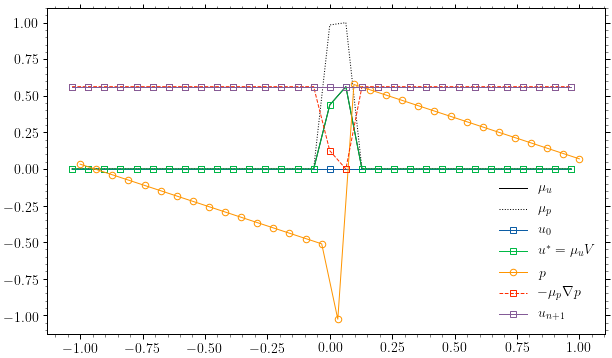

In [187]:
plt.plot(xs, 1.-mu_u,'-k', label=r'$\mu_u$')
plt.plot(xs, 1.-mu_p,':k', label=r'$\mu_p$')
plt.plot(xs, u0,  '-s', label=r'$u_0$')
plt.plot(xs, us, '-s', label=r'$u^*=\mu_uV$')
plt.plot(x, p, '-o', label=r'$p$')
plt.plot(xs, -mu_p*ns.grad(p, dx), '--s', label=r'$-\mu_p\nabla p$')
plt.plot(xs, u_n, '-s', label=r'$u_{n+1}$')
plt.legend()
plt.show()

as long asthe right amount of divergence (from the body BC's) is introduced into the flow, and the correct pressure BC's are imposed, the correct answer is obtained.

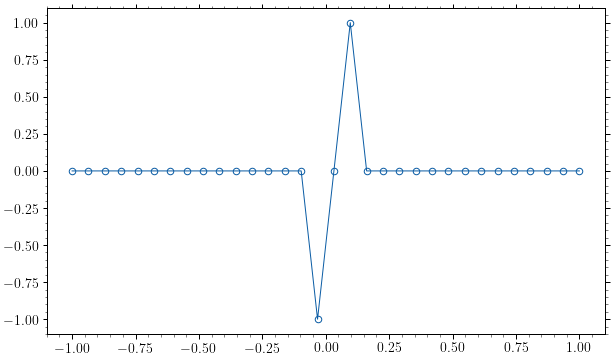

In [184]:
mu_u = 1.-kern_var(xs, 0.5*dx, 1, 0.5)
plt.plot(x, ns.div(mu_u), '-o');